In [1]:
import modin.pandas as modin_pd
import pandas as pd

In [2]:
import time
import warnings
import matplotlib.pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [15]:
start_pd = time.time()
df = pd.read_csv('creditcard.csv')
end_pd = time.time()
print("normal_pd loading time: " + str(end_pd-start_pd))
start_modin_pd = time.time()
df = modin_pd.read_csv('creditcard.csv')
end_modin_pd = time.time()
print("modin_pd loading time: " + str(end_modin_pd-start_modin_pd))

normal_pd loading time: 1.4126214981079102
modin_pd loading time: 0.16202569007873535


In [4]:
print(df.shape)
print(df.columns)
display(df.head())

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Data Preprocessing

## Feature Engineering

### Null Value Detection

In [5]:
def check_missing_values(df):
    # 统计每个特征的缺失值数量
    missing_values = df.isnull().sum()

    # 获取包含缺失值的特征列表
    features_with_missing_values = missing_values[missing_values > 0].index.tolist()

    # 打印结果
    if not features_with_missing_values:
        print("数据集中没有缺失值。")
    else:
        print("包含缺失值的特征列表:")
        for feature in features_with_missing_values:
            print(f"{feature}: {missing_values[feature]} 个缺失值")

check_missing_values(df)

数据集中没有缺失值。


### Correlation Analysis

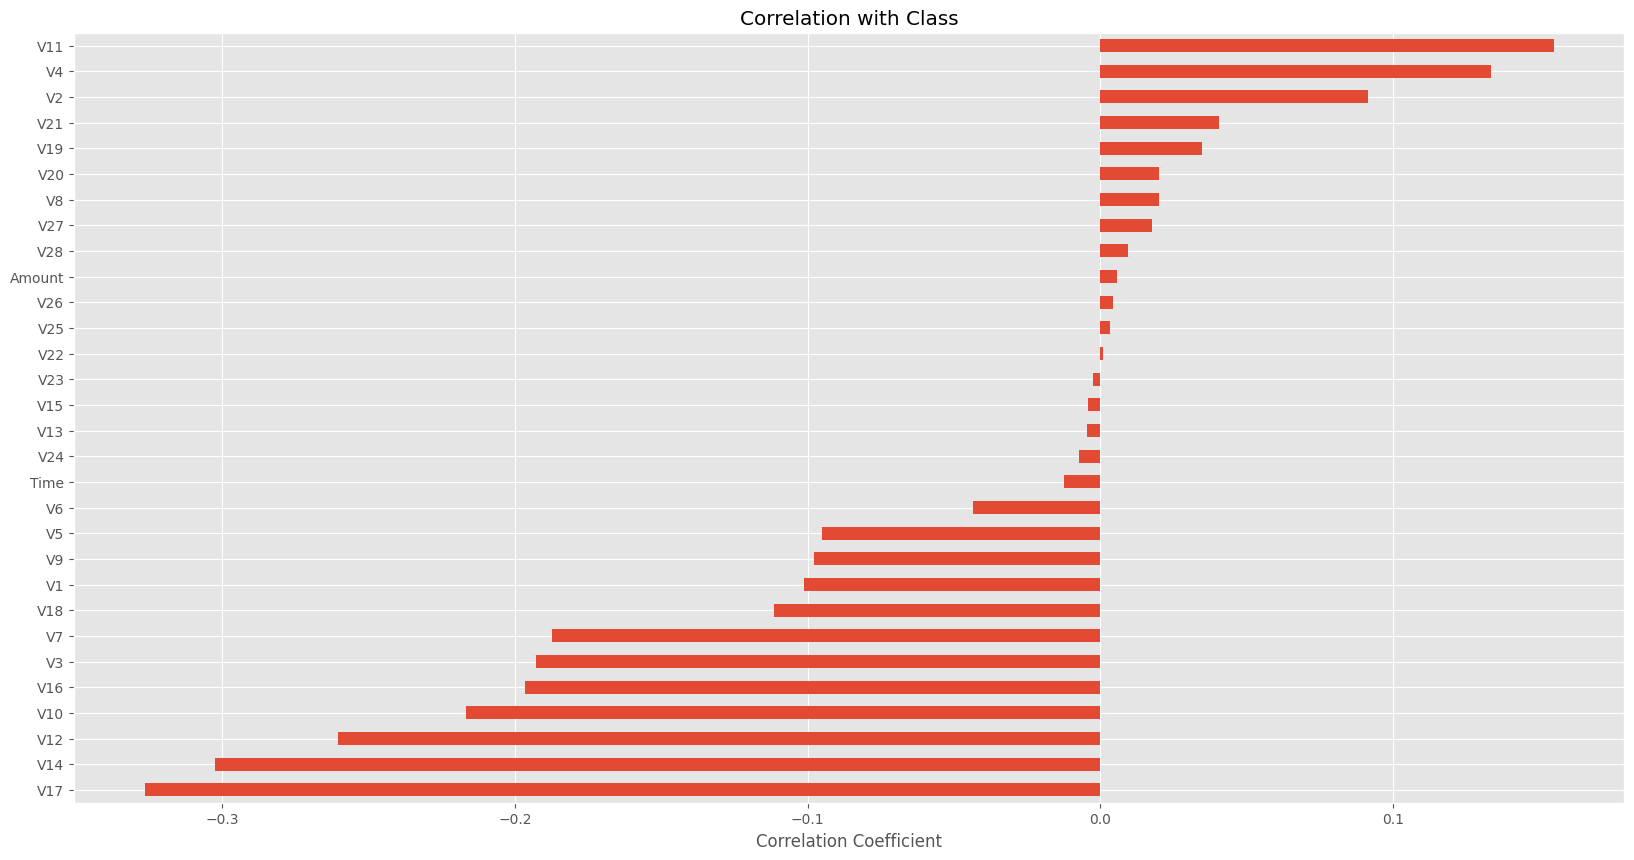

corr_features: ['V2', 'V3', 'V4', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Class']


In [6]:
def corr_analyze(df, target_label):
    # 计算特征与目标标签的相关性
    correlation_with_target = df.corr()[target_label]

    # 绘制柱状图
    correlation_with_target.drop(target_label).sort_values().plot(kind='barh',figsize=(20, 10))
    plt.title(f'Correlation with {target_label}')
    plt.xlabel('Correlation Coefficient')
    plt.show()

    threshold = 0.05
    return correlation_with_target[correlation_with_target.abs() > threshold].index.tolist()[1:]

corr_features = corr_analyze(df, 'Class')
print("corr_features: {a}".format(a=corr_features))

通过上图各特征关于标签的皮尔逊相关系数，它的数值对于有线性关系的两个变量来说绝对值越接近1越好。因此我们可以发现，有部分特征的皮尔逊相关系数绝对值在0附近，因此可以考虑去掉这些特征。（这个只反映线性的相关性，因此对于非线性相关的变量，还需进一步分析）

### Mutual Information Analysis

In [7]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


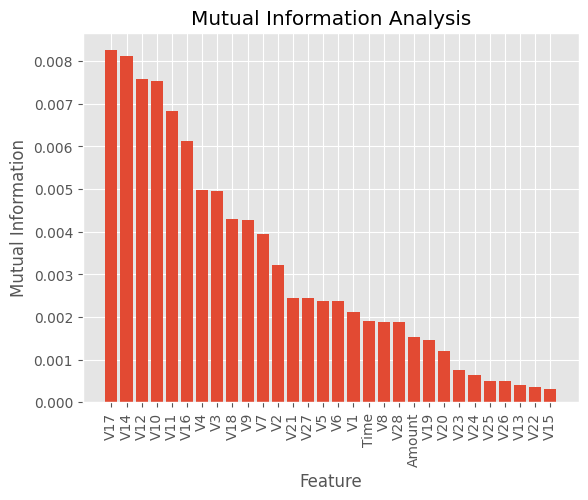

<Figure size 4000x1200 with 0 Axes>

mutual_info_features: ['V17', 'V14', 'V12', 'V10', 'V11', 'V16', 'V4', 'V3', 'V18', 'V9', 'V7', 'V2', 'V21', 'V27', 'V5', 'V6', 'V1']


In [8]:
from sklearn.feature_selection import mutual_info_classif

def mutual_information_analysis(X, y):
    # 计算互信息
    mi_scores = []

    for feature in X.columns:
        mi_score = mutual_info_classif(X[feature].values.reshape(-1, 1), y)[0]
        mi_scores.append(mi_score)

    # 创建一个 DataFrame 用于可视化
    mi_df = modin_pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mi_scores})

    # 按互信息值降序排序
    mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False)

    # 绘制互信息图表
    plt.bar(mi_df['Feature'], mi_df['Mutual_Information'])
    plt.xlabel('Feature')
    plt.ylabel('Mutual Information')
    plt.title('Mutual Information Analysis')
#     plt.xticks(rotation=45, ha='right'
    plt.xticks(rotation=90)
    plt.figure(figsize=(40, 12))
    plt.show()

    # 筛选互信息大于阈值的特征
    threshold = 0.002  # 设置互信息阈值
    selected_features = mi_df[mi_df['Mutual_Information'] > threshold]['Feature'].tolist()

    return selected_features

mutual_info_features = mutual_information_analysis(df.drop(columns="Class"), df['Class'])
print("mutual_info_features: {a}".format(a=mutual_info_features))

### Variance Analysis

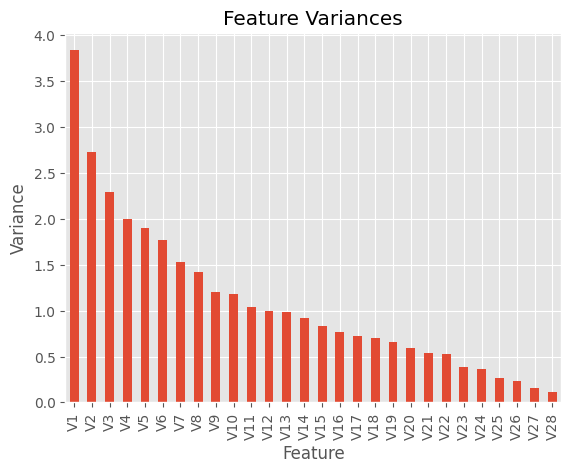

variance_features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22']


In [9]:
from sklearn.feature_selection import VarianceThreshold

def variance_analysis(data):
    variances = data.var()
    
#     plt.figure(figsize=(12, 6))
    variances.plot(kind='bar')
    plt.title('Feature Variances')
    plt.xlabel('Feature')
    plt.ylabel('Variance')
    plt.show()
    threshold = 0.5
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(data)
    
    # 获取通过阈值筛选后的特征
    selected_features = data.columns[selector.get_support()].tolist()

    return selected_features

variance_features = variance_analysis(df.drop(columns=["Class",'Time','Amount']))
print("variance_features: {a}".format(a=variance_features))


In [10]:
def get_common_features(feature_lists):
    # 将第一个列表转换为集合
    common_elements = set(feature_lists[0])
    
    # 对所有其他列表取交集
    for feature_list in feature_lists[1:]:
        common_elements = common_elements.intersection(feature_list)
    
    # 转换为列表并返回
    result_list = list(common_elements)
    result_list.append('Amount')
    result_list.append('Time')
    return result_list

selected_features = get_common_features([corr_features, variance_features, mutual_info_features])
print(selected_features)

['V18', 'V2', 'V5', 'V3', 'V17', 'V16', 'V4', 'V12', 'V9', 'V7', 'V11', 'V14', 'V10', 'Amount', 'Time']


In [11]:
print(selected_features)
selected_df = df[selected_features + ['Class']]
display(selected_df.head())

['V18', 'V2', 'V5', 'V3', 'V17', 'V16', 'V4', 'V12', 'V9', 'V7', 'V11', 'V14', 'V10', 'Amount', 'Time']


,V18,V2,V5,V3,V17,V16,V4,V12,V9,V7,V11,V14,V10,Amount,Time,Class
0,0.025791,-0.072781,-0.338321,2.536347,0.207971,-0.470401,1.378155,-0.617801,0.363787,0.239599,-0.551600,-0.311169,0.090794,149.62,0.0,0
1,-0.183361,0.266151,0.060018,0.166480,-0.114805,0.463917,0.448154,1.065235,-0.255425,-0.078803,1.612727,-0.143772,-0.166974,2.69,0.0,0
2,-0.121359,-1.340163,-0.503198,1.773209,1.109969,-2.890083,0.379780,0.066084,-1.514654,0.791461,0.624501,-0.165946,0.207643,378.66,1.0,0
3,1.965775,-0.185226,-0.010309,1.792993,-0.684093,-1.059647,-0.863291,0.178228,-1.387024,0.237609,-0.226487,-0.287924,-0.054952,123.50,1.0,0
4,-0.038195,0.877737,-0.407193,1.548718,-0.237033,-0.451449,0.403034,0.538196,0.817739,0.592941,-0.822843,-1.119670,0.753074,69.99,2.0,0


In [12]:
selected_df.columns

Index(['V18', 'V2', 'V5', 'V3', 'V17', 'V16', 'V4', 'V12', 'V9', 'V7', 'V11',
       'V14', 'V10', 'Amount', 'Time', 'Class'],
      dtype='object')

## Normalization

In [13]:
from sklearn.preprocessing import StandardScaler
from daal4py import normalization_zscore

def normalize_features(X, columns_to_normalize):
    # 复制原始数据框，以免修改原始数据
    X_normalized = X.copy()

    # 初始化 StandardScaler
    scaler = StandardScaler()

    # 对指定列进行归一化
    X_normalized[columns_to_normalize] = scaler.fit_transform(X[columns_to_normalize])

    return X_normalized

x = selected_df.drop('Class', axis=1)
y = selected_df['Class']
x = normalize_features(x, ['Time', 'Amount'])
display(x.head())

,V18,V2,V5,V3,V17,V16,V4,V12,V9,V7,V11,V14,V10,Amount,Time
0,0.025791,-0.072781,-0.338321,2.536347,0.207971,-0.470401,1.378155,-0.617801,0.363787,0.239599,-0.551600,-0.311169,0.090794,0.244964,-1.996583
1,-0.183361,0.266151,0.060018,0.166480,-0.114805,0.463917,0.448154,1.065235,-0.255425,-0.078803,1.612727,-0.143772,-0.166974,-0.342475,-1.996583
2,-0.121359,-1.340163,-0.503198,1.773209,1.109969,-2.890083,0.379780,0.066084,-1.514654,0.791461,0.624501,-0.165946,0.207643,1.160686,-1.996562
3,1.965775,-0.185226,-0.010309,1.792993,-0.684093,-1.059647,-0.863291,0.178228,-1.387024,0.237609,-0.226487,-0.287924,-0.054952,0.140534,-1.996562
4,-0.038195,0.877737,-0.407193,1.548718,-0.237033,-0.451449,0.403034,0.538196,0.817739,0.592941,-0.822843,-1.119670,0.753074,-0.073403,-1.996541


## Split The Dataset

In [14]:
# from sklearn.model_selection import train_test_split

# 划分数据集 need not to be executed twice
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 保存训练集和测试集
# x_train.to_csv('x_train.csv', header = True, index = False)
# x_test.to_csv('x_test.csv', header = True, index = False)
# y_train.to_csv('y_train.csv', header = True, index = False)
# y_test.to_csv('y_test.csv', header = True, index= False)